## **MA5606 Tópicos Matemáticos en Aprendizaje de Máquinas, Redes Neuronales y Aprendizaje Profundo**

### **Tarea 1: Redes neuronales feedfoward y PINNs**

**Profesores: Claudio Muñoz y Joaquín Fontbona**

**Auxiliares: Javier Maass y Diego Olguín**

**Nombres integrantes: COMPLETAR**

**Instrucciones:**

- **Fecha de entrega:** **26 de abril de 2024, a las 23:59.**

- **Importante:** Si trabaja desde el link de Google Colab (muy recomendable para trabajar con DeepXDE) debe hacer un copia en su Drive antes de trabajar, de lo contrario se podrían no guardar sus códigos.

- Debe entregar un Jupyter Notebook (archivo .ipynb) con sus código en Python. Le pueden ser de mucha utilidad los códigos vistos en la actividad práctica.

- Sus códigos deben estar comentados y ordenados. Además, en formato texto debe colocar todas sus conclusiones y resultados pedidos que deban ser redactados.

- En todos los ejercicios se le pide hacer al menos un gráfico. Los gráficos que realicen deben ser claros, con títulos y nombres en los ejes, junto con leyendas si es que corresponde.

In [1]:
# Librerías

# Numpy y matplotlib, junto con seaborn, para gráficos un poco mejores
import numpy as np
import matplotlib.pyplot as plt

# Puede ser útil para hacer gráficos con barras de colores
from mpl_toolkits.axes_grid1 import make_axes_locatable

import seaborn as sns

sns.set_theme()

# PyTorch y módulos que serán necesario
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import pandas as pd
import math
from scipy.special import roots_legendre

torch.manual_seed(115)

## **Ejercicio 1**

El objetivo de este ejercicio es estudiar la aproximación vía redes neuronales del problema de frontera

$$ y''(x) + \frac{\pi^2}{4} y(x) = 0 $$
$$ y(-1) = y(1) = 0, \, y(0) = 1$$

Para ello utilice redes de 1 capa oculta de ancho $N$, usando $N = \{ 10, 20, 30, 100\}$. Entrene la red con 600 iteraciones del algoritmo ``Adam``.

En cada caso grafique la evolución de la función de pérdida en las iteraciones de entrenamiento, además de la red evaluada en puntos en el intervalo $[-1,1]$ y compare con la solución analítica:

$$ y(x) = \cos \left (\frac{\pi}{2} x \right ) $$

#### **Solucuión Ejercicio 1**

Comenzamos definiendo una clase de para redes neuronales de ancho único que nos permita definir la dimensión del input, la duimensión del output, la cantidad de capas ocultas, el ancho de las capas ocultas y la función de activación que deseamos aplicar.

In [2]:
# Clase para crear redes neuronales
class NeuralNetwork(nn.Module):
    """
    Clase que define una red neuronal con una cantidad de capas y neuronas por capa definida por el usuario.
    Es una subclase de nn.Module, la clase base para todos los módulos de PyTorch.
    """

    def __init__(
        self,
        dim_input: int,
        dim_output: int,
        n_hidden_layers: int,
        width: int,
        activation: callable,
    ) -> None:
        """
        Constructor de la clase, que recibe los parámetros necesarios para crear una red neuronal.

        Args:
            - dim_input (int): Dimensión de la entrada.
            - dim_output (int): Dimensión de la salida.
            - n_hidden_layers (int): Número de capas internas.
            - wide (int): Ancho de las capas internas.
            - activation (callable): Función de activación.

        Returns:
            - None

        Rasies:
            - AssertionError: Si dim_input, dim_output, n_hidden_layers o wide no son enteros positivos.
            - AssertionError: Si activation no es una función.
        """
        super().__init__()  # Inicia el constructor de la clase base (nn.Module)

        for int_input, name in zip(
            [dim_input, dim_output, n_hidden_layers, width],
            ["dim_input", "dim_output", "n_hidden_layers", "width"],
        ):
            assert (
                isinstance(int_input, int) and int_input > 0
            ), f"Error en los parámetros de la red. Error: {int_input} ({name}) debe ser un entero positivo."
        assert callable(
            activation
        ), "Error en los parámetros de la red. Error: activation debe ser una función."

        self.first_layer = nn.Linear(dim_input, width)
        self.inner_layers = nn.ModuleList(
            [nn.Linear(width, width) for _ in range(n_hidden_layers - 1)]
        )
        self.last_layer = nn.Linear(width, dim_output)

        self.activation = activation

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Describe cómo se calcula la salida de la red a partir de la entrada.

        Args:
            - x (torch.Tensor): Tensor de entrada.

        Returns:
            - torch.Tensor: Tensor de salida.
        """
        x = self.activation(self.first_layer(x))
        for layer in self.inner_layers:
            x = self.activation(layer(x))
        x = self.last_layer(x)

        return x


"""
Notas:
- Un modulo de PyTorch es una red neuronal creada con PyTorch.
- nn.Module es la clase base para todos los módulos de PyTorch.
- nn.ModuleList es similar a las listas de python diseñada específicamente para almacenar modulos.
- nn.Linear(in_features(int), out_features(int)) crea una transformación afín desde una capa de in_features dimensiones a una capa de out_features dimensiones (y=xA^T + b).
- super().__init__() llama al constructor de la clase base. Es necesario para cualquier modulo de PyTorch.
- forward describe cómo se calcula la salida de la red a partir de la entrada.
"""

'\nNotas:\n- Un modulo de PyTorch es una red neuronal creada con PyTorch.\n- nn.Module es la clase base para todos los módulos de PyTorch.\n- nn.ModuleList es similar a las listas de python diseñada específicamente para almacenar modulos.\n- nn.Linear(in_features(int), out_features(int)) crea una transformación afín desde una capa de in_features dimensiones a una capa de out_features dimensiones (y=xA^T + b).\n- super().__init__() llama al constructor de la clase base. Es necesario para cualquier modulo de PyTorch.\n- forward describe cómo se calcula la salida de la red a partir de la entrada.\n'

Definimos una función `derivative` que toma una función `f`, un subconjunto del dominio `x` y un orden `order` y entrega la `order`-ésima derivada de `f` en los puntos `x` obtenida mediante diferenciación automática

In [3]:
def derivative(
    f: callable, x: torch.Tensor, order: int = 1
) -> torch.Tensor:
    """
    Toma una función y una colección del dominio y entrega la derivada del orden deciado de la función en esos puntos en un tensor.

    Args:
        - f (callable): Función de la que se quiere calcular la derivada.
        - x (torch.Tensor): Tensor de puntos en los que se quiere calcular la derivada.
        - order (int): Orden de la derivada que se quiere calcular.

    Returns:
        - torch.Tensor: Tensor con las derivadas de f en los puntos de variable.

    Raises:
        - AssertionError: Si f no es una función.
        - AssertionError: Si x no es un tensor.

    """
    assert callable(f), "Error: f debe ser una función."
    assert isinstance(x, torch.Tensor), f"Error: variable debe ser un tensor pero es {type(x)}."
    assert (
        isinstance(order, int) and order > 0
    ), "Error: order debe ser un entero positivo."

    x.requires_grad_()
    y = f(x).unsqueeze(0)

    for _ in range(order):
        y = torch.autograd.grad(y.sum(), x, create_graph=True)[0]

    return y

Definimos la función analítica, los puntos iniciales y sus valores esperados. Definimos además los meta-parámetros como el learning rate, el ancho de las redes, la cantidad de puntos interiores, el peso que tendrán las condiciones iniciales en comparación el peso de la dinámica en la función de error y la cantidad de iteraciones del algorítmo Adam.

Definimos, además, la variable `initial_relevance` que determian el peso asociado a cada condición inicial a la hora de entrenar. En este caso optamos por darle mayor prioridad al punto $0$ pues esto llevaba a menor error de entrenamiento. Una posible razon de esto es que, ignorando la condición inicial en $0$, la función constante $x\mapsto 0$ es solución. Aumentar la relevancia de de la condición $0\mapsto 1$, nos aleja más rápidamente de esto.

In [4]:
# El problema:
analitic = lambda x: torch.cos((np.pi / 2) * x)
x0 = torch.tensor([[-1.0], [0.0], [1.0]])
y0 = torch.tensor([[0.0], [1.0], [0.0]])
initial_relevance = torch.tensor([[1.0], [3.0], [1.0]])

# Parametros
gamma = 0.001  # Learning rate.

# Anchos de las redes
N = [
     10,
     20, 
     30, 
     100
     ]  

# Cardinalidad de la partición de [-1,1].
resolution = 500  

# Pesos de las condiciones iniciales vs la dinámica
w0 = 0.5 # Peso condición inicial
wphi = 1 - w0 # Peso dinámica
w = (w0, wphi)  # Pesos para la función error.

# Iteraciones de entrenamiento.
iters = 600  

Definimos los puntos interiores:
Los puntos interiores son las raíces del `resolution`-ésimo polinomio de Legendre. Esto en vista de usar la cuadratura de Gauss-Legendre (GL) en la función de error
$$\sum_{i=1}^n \lambda_i f(x_i)\approx \int_{-1}^1 f(x)\, dx.$$
donde $\lambda$ corresponde a los pesos de GL. Esta particion y pesos integran correctamente polinómios de orden $2n-1$ o menor en el intervalo $[-1,1]$.
La motivación detrás de esto, es que, para problemas de baja dimensionalidad ($d\leq 3$), este tipo de cuadraturas resulta una mejor apriximación que escojer una partición aleatoria. Esto es relevante pues el error de generalisación está acotado, en parte, por el error de cuadratura: esta implementación nos permite generalizar mejor.

In [5]:
X, lamb= roots_legendre(resolution)
X = torch.tensor(X,dtype=torch.float32).unsqueeze(1).requires_grad_()
lamb = torch.tensor(lamb,dtype=torch.float32).unsqueeze(1)

Creamos las redes neuronales con los anchos especificados en `N` ($\{10,20,30,100\}$) y sus respectivos optimizadores. En esta instancia, usaremos el algorítmo Adam para realizar la optimisación.

In [6]:
# Listas de redes y optimizadores
neural_list = nn.ModuleList()
optimizer_list = []

# Creación de las redes y optimizadores
for n in N:
    NN = NeuralNetwork(
        dim_input=1, dim_output=1, n_hidden_layers=1, width=n, activation=F.tanh
    )
    neural_list.append(NN)

    optimizer = optim.Adam(NN.parameters(), lr=gamma)
    optimizer_list.append(optimizer)

Definimos la función de error. En el caso de las condiciones de borde, definimos el error como la suma de los errores cuadrados multiplicados por su respectivo peso (recordemos que priorizamos la conduición $0\mapsto 1$). Para el error de la física, usamos la cuadratura de Gauss-Legendre mencionada anteriormente. El error total, serrá el promedio ponderado de estos dos errores.

Revisamos, además, que el error de la función analítica sea pequeño.

In [7]:
# Función objetivo
def error(NN: NeuralNetwork, X: torch.Tensor) -> torch.Tensor:
    """
    Función de error para la PINNs del ejercicio 1.

    Args:
        - NN (nn.Module): Red neuronal.

    Returns:
        - torch.Tensor: Valor del error.

    Raises:
        - AssertionError: Si NN no es una red neuronal.
    """
    assert callable(NN), "Error: NN debe ser un callable."

    # Error inicial
    NN_y0 = NN(x0)
    E0 = torch.sum((NN_y0 - y0)**2 * initial_relevance)
    
    epsilon = derivative(NN, X, order=2) + ((np.pi**2) / 4) * NN(X)
    Ephi = torch.sum((epsilon**2) * lamb)

    objective = w[0] * E0 + w[1] * Ephi

    return objective

analitic_error = error(analitic, X).item()
print("Error de la función analítica:", analitic_error)
assert math.isclose(analitic_error, 0, abs_tol=1e-10), "Error en la función error."

Error de la función analítica: 2.6506586571386874e-14


Definimos el argumento que le entregaremos a la función `step` del optimizer.

In [8]:
# Función necesaria para el optimizador
def closure(
    NN: NeuralNetwork, optimizer: optim.Optimizer, X: torch.Tensor
) -> torch.Tensor:
    optimizer.zero_grad()  # Se actualizan los pesos haciendo gradiente 0
    loss = error(NN, X)  # Se calcula la función de pérdida
    loss.backward()  # Diferenciación automática
    return loss

Definimos la función que entrena la red neuronal y las listas donde guardamos la información de entrenamiento.

In [10]:
loss_record = {f"{width}": [] for width in N}


def train(NN: NeuralNetwork, X: torch.Tensor, optimizer: optim.Optimizer) -> None:
    """
    Función que entrena una red neuronal.

    Args:
        - NN (nn.Module): Red neuronal.
        - optimizer (optim.Optimizer): Optimizador.
        - width (int): Ancho de la red.

    Returns:
        - None

    Raises:
        - AssertionError: Si NN no es una red neuronal.
        - AssertionError: Si X no es un tensor.
        - AssertionError: Si optimizer no es un optimizador.
    """
    assert isinstance(NN, nn.Module), "Error: NN debe ser una red neuronal."
    assert isinstance(
        X, torch.Tensor
    ), f"Error: X debe ser un tensor pero es {type(X)}."
    assert isinstance(
        optimizer, optim.Optimizer
    ), "Error: optimizer debe ser un optimizador."

    width = NN.first_layer.out_features
    data = {"Iteración": [], "Pérdida": []}
    try:
        for iter in range(1, iters + 1):

            # Guardamos la pérdida calculada
            error_value = error(NN, X).item()
            loss_record[f"{width}"] += [error_value]
            # Paso del optimizador
            optimizer.step(lambda: closure(NN, optimizer, X))

            # Imprimimos la pérdida en cada iteración, cada ciertas iteraciones
            if iter % 100 == 0:
                data["Iteración"].append(iter)
                data["Pérdida"].append(error_value)
            

    # Hacer esta sentencia try, except de esta forma hace que
    # podamos parar el entrenamiento sin que haya error
    except KeyboardInterrupt:
        pass
    data = pd.DataFrame(data)
    print(data.to_string(index=False))

Realizamos el entrenamiento de cada una de las redes neuronales.

In [11]:
for NN, optimizer in zip(neural_list, optimizer_list):
    print(f"Width = {NN.first_layer.out_features}:")
    train(NN, X, optimizer)

Width = 10:
 Iteración  Pérdida
       100 1.141696
       200 0.918653
       300 0.699832
       400 0.504818
       500 0.341026
       600 0.213603
Width = 20:
 Iteración  Pérdida
       100 1.262401
       200 1.090439
       300 0.912472
       400 0.713645
       500 0.531554
       600 0.400437
Width = 30:
 Iteración  Pérdida
       100 0.888913
       200 0.485226
       300 0.212424
       400 0.076069
       500 0.022346
       600 0.005833
Width = 100:
 Iteración  Pérdida
       100 0.466113
       200 0.082168
       300 0.010365
       400 0.001177
       500 0.000203
       600 0.000074


Graficamos el progreso de la función error a lo largo del entrenamiento.

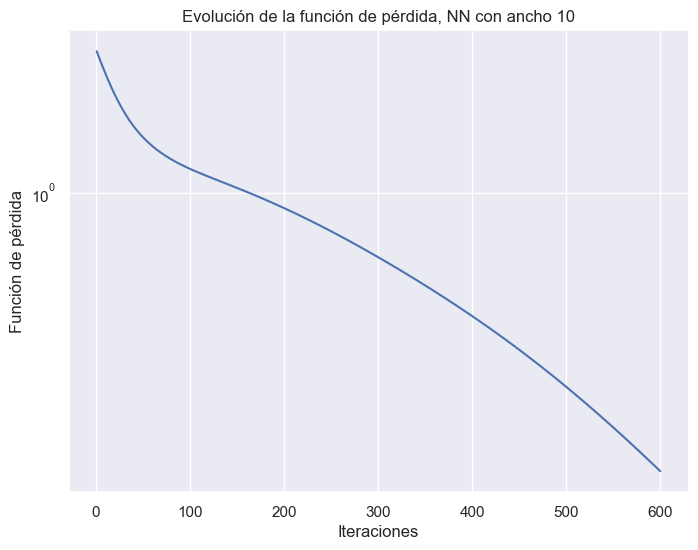

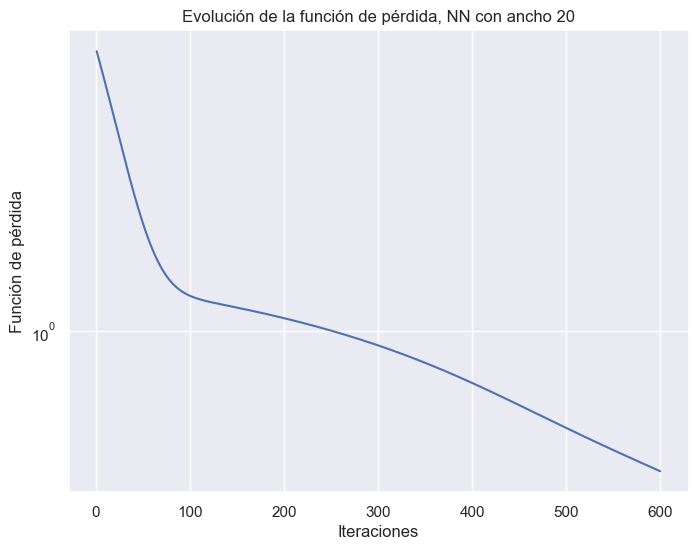

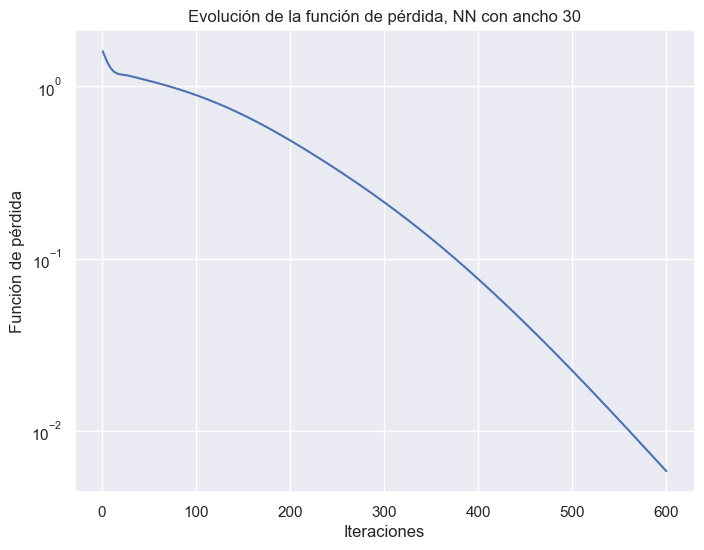

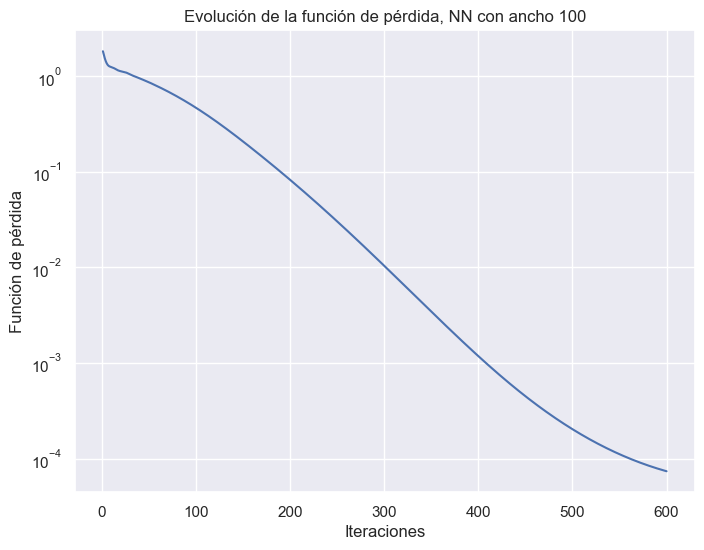

In [12]:
for width in N:
    # Gráfico de la función de pérdida en las iteraciones
    plt.figure(figsize=(8, 6))
    plt.plot(range(1, iters + 1), loss_record[f"{width}"])
    plt.xlabel("Iteraciones")
    plt.ylabel("Función de pérdida")
    plt.yscale("log")
    plt.title(f"Evolución de la función de pérdida, NN con ancho {width}")
    plt.show()


Graficamos la red neuronal resultante para cada uno de los anchos y lo comparamos con la función analítica en puntos aleatorios del dominio $[-1,1]$.

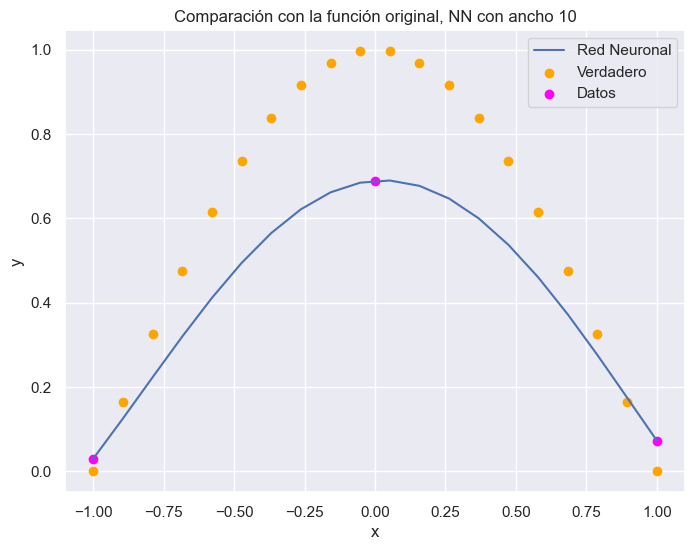

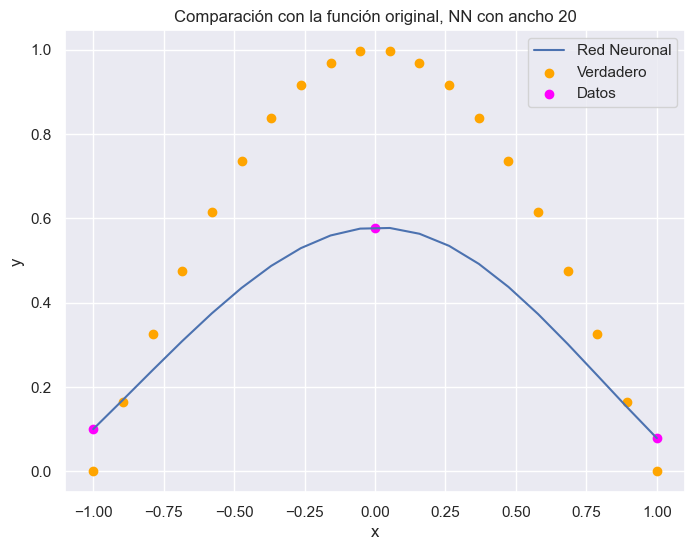

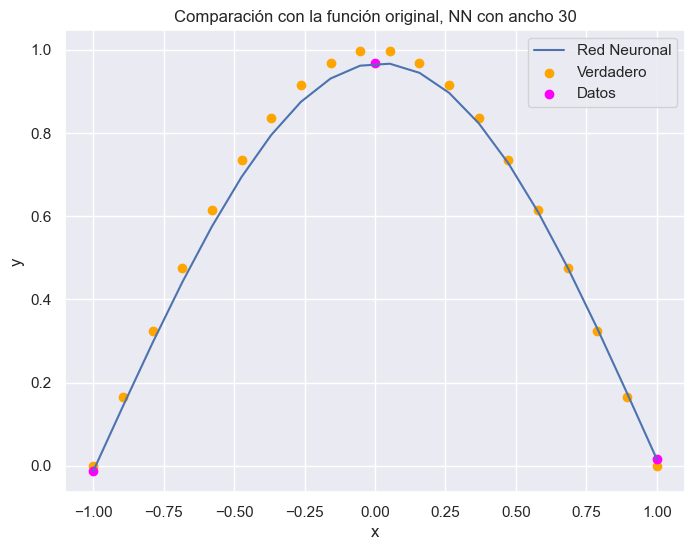

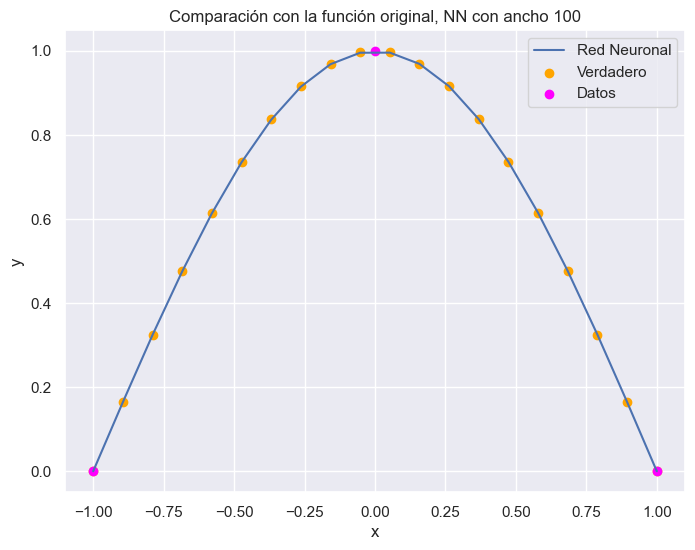

In [13]:
for NN in neural_list:
    N_test = 20
    X_test = torch.linspace(-1, 1, N_test).reshape((N_test, 1))
    y_test = NN(X_test).squeeze()
    y_true = analitic(X_test).squeeze()

    datax = [x0[0][0], x0[1][0], x0[2][0]]
    datay = [NN(x0).detach()[0][0], NN(x0).detach()[1][0], NN(x0).detach()[2][0]]

    fix, ax = plt.subplots(1, 1, figsize=(8, 6))
    ax.plot(X_test, y_test.detach(), label="Red Neuronal")
    ax.scatter(X_test, y_true, label="Verdadero", c="orange")
    ax.scatter(datax, datay, c="magenta", label="Datos")
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_title(f"Comparación con la función original, NN con ancho {NN.first_layer.out_features}")
    ax.legend()
    plt.show()


## **Ejercicio 2**



Veremos nuevamente el problema de EDP de Helmholtz

$$ -\Delta u - k_0^2 u = f, \quad \Omega = (0,1)^2 $$
$$ u = 0, \quad ∂ Ω $$

Que tiene solución analítica

$$ u(x, y) =  \sin (k_0 x) \sin (k_0 y)$$

Cuando $f(x,y) = k_0^2 \sin (k_0 x) \sin (k_0 y)$. Considere $k_0 = 2 n \pi$ y entrene una red neuronal de 3 capas, 100 neuronas por capa, función de activación seno y 3000 iteraciones del optimizador Adam, que resuelva el problema para $n \in \{ 1, 3, 5 \}$. Grafique la función de pérdida en función de las iteraciones de entrenamiento y el resultado de la red, comparando este con la solución analítica. ¿Qué resultado observa para los distintos $n$ propuestos?

In [15]:
# Instalamos e importamos la librería
import deepxde as dde


# Importamos Tensorflow, que es el backend que utilizaremos
import tensorflow as tf

Using backend: tensorflow
Other supported backends: tensorflow.compat.v1, pytorch, jax, paddle.
paddle supports more examples now and is recommended.


#### **Solucuión Ejercicio 2:**

Iteramos sobre los valores $\{1,3,5\}$ la implementasción mediante PINNs para el problema de Helmholtz.

Compiling model...
'compile' took 0.900996 s

Training model...

Step      Train loss    Test loss     Test metric
0         [3.91e+02]    [3.91e+02]    []  
500       [3.88e-02]    [3.88e-02]    []  
1000      [7.84e-03]    [7.84e-03]    []  
1500      [2.13e-03]    [2.13e-03]    []  
2000      [2.56e-03]    [2.56e-03]    []  
2500      [1.45e-03]    [1.45e-03]    []  
3000      [1.38e-03]    [1.38e-03]    []  

Best model at step 3000:
  train loss: 1.38e-03
  test loss: 1.38e-03
  test metric: []

'train' took 104.896425 s



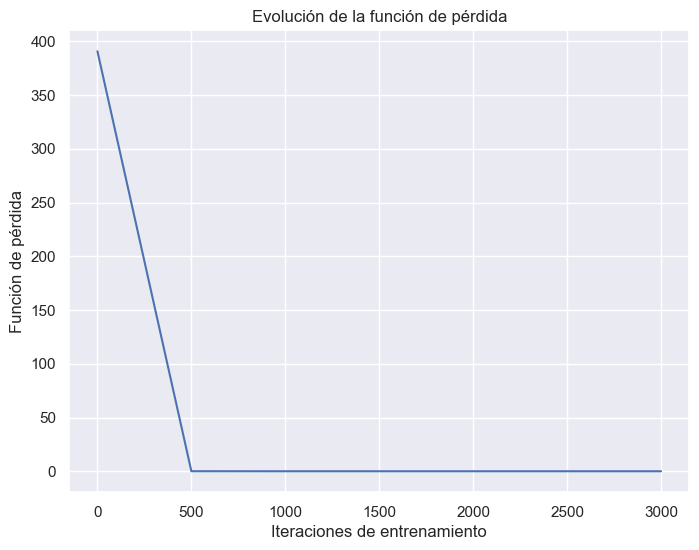

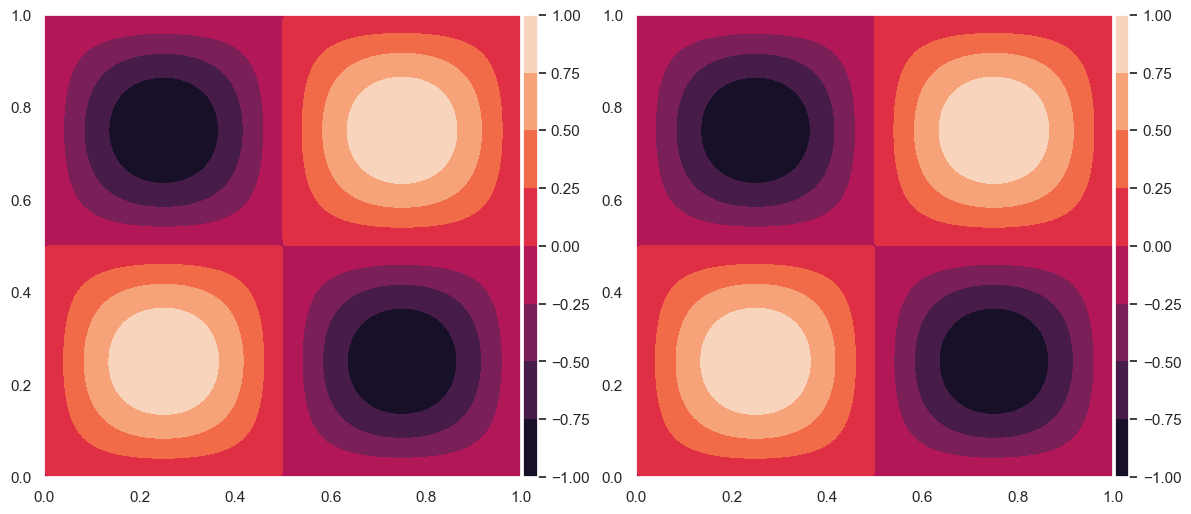

Compiling model...
'compile' took 0.007632 s

Training model...

Step      Train loss    Test loss     Test metric
0         [3.17e+04]    [3.17e+04]    []  
500       [3.17e+04]    [3.17e+04]    []  
1000      [3.17e+04]    [3.17e+04]    []  
1500      [2.70e+04]    [2.70e+04]    []  
2000      [1.82e+04]    [1.82e+04]    []  
2500      [2.23e+03]    [2.23e+03]    []  
3000      [4.10e+02]    [4.10e+02]    []  

Best model at step 3000:
  train loss: 4.10e+02
  test loss: 4.10e+02
  test metric: []

'train' took 91.643972 s



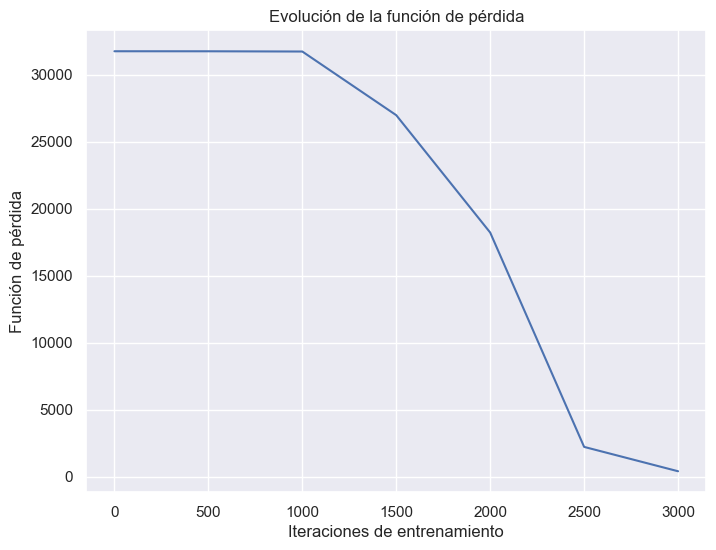

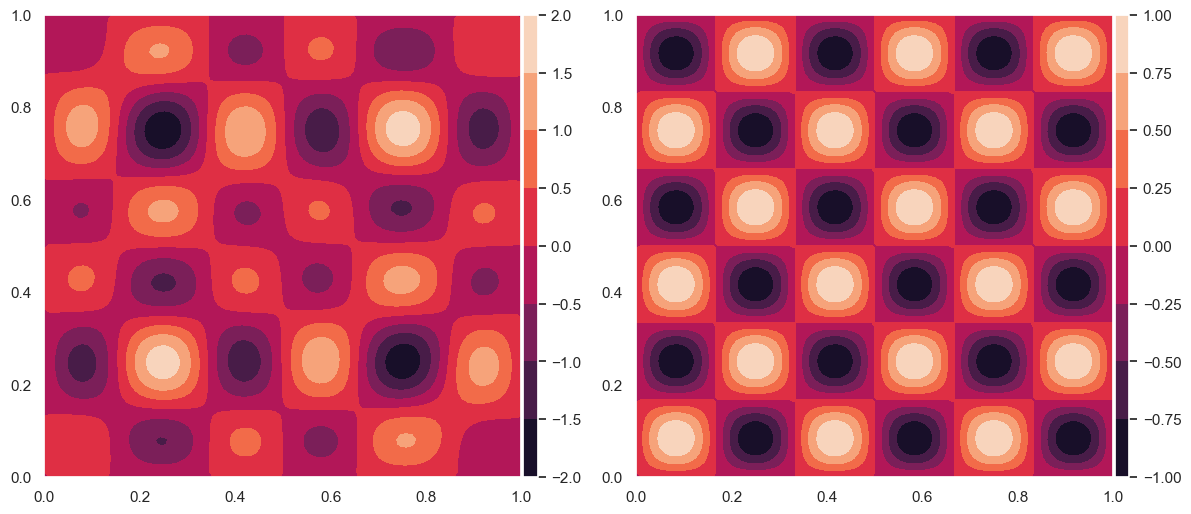

Compiling model...
'compile' took 0.003806 s

Training model...

Step      Train loss    Test loss     Test metric
0         [2.44e+05]    [2.44e+05]    []  
500       [2.44e+05]    [2.44e+05]    []  
1000      [2.33e+05]    [2.33e+05]    []  
1500      [1.76e+05]    [1.76e+05]    []  
2000      [9.98e+04]    [9.98e+04]    []  
2500      [2.88e+04]    [2.88e+04]    []  
3000      [9.38e+03]    [9.38e+03]    []  

Best model at step 3000:
  train loss: 9.38e+03
  test loss: 9.38e+03
  test metric: []

'train' took 85.326991 s



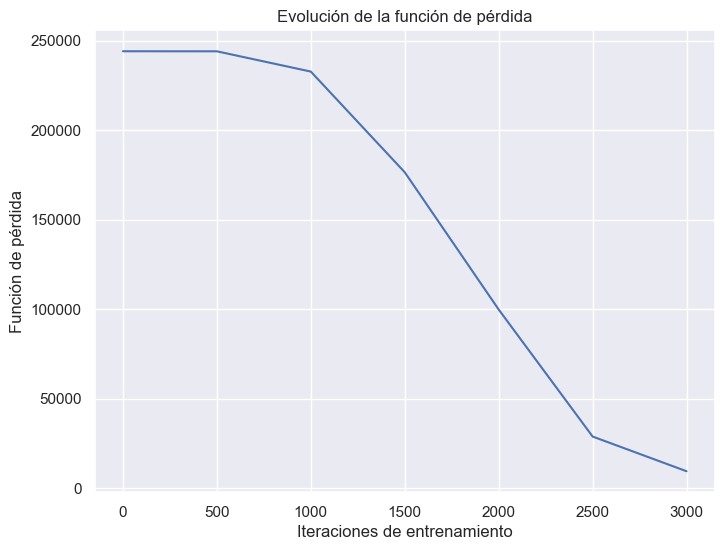

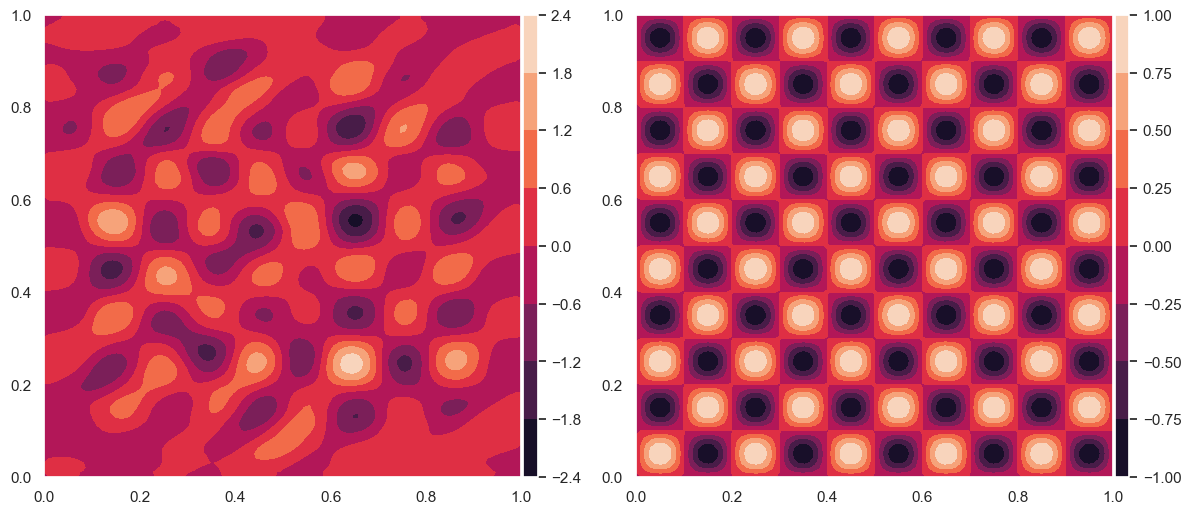

In [16]:
for n in {1, 3, 5}:
    # Dimensión de input
    dim_input = 2

    # Dimensión de output
    dim_output = 1

    # Iteraciones del optimizador
    iterations = 3000

    # Número de onda
    k0 = 2 * np.pi * n

    weights = (1, 1)

    # Geometría
    geom = dde.geometry.Rectangle([0, 0], [1, 1])

    # Frontera
    def boundary(_, on_boundary):
        return on_boundary

    # Dado que fijaremos la condición de borde, no se la daremos a la red directamente
    bc = []

    def pde(x, y):
        dy_xx = dde.grad.hessian(y, x, i=0, j=0)
        dy_yy = dde.grad.hessian(y, x, i=1, j=1)

        f = k0**2 * tf.sin(k0 * x[:, 0:1]) * tf.sin(k0 * x[:, 1:2])
        return -dy_xx - dy_yy - k0**2 * y - f

    data = dde.data.PDE(geom, pde, bc, num_domain=400)

    # Parámetros de la red
    wide, n_layers, activation = 150, 3, "sin"

    # Red neuronal
    net = dde.nn.FNN(
        [dim_input] + [wide] * n_layers + [dim_output], activation, "Glorot uniform"
    )

    # Transformación
    def transform(x, y):
        res = x[:, 0:1] * (1 - x[:, 0:1]) * x[:, 1:2] * (1 - x[:, 1:2])
        return res * y

    # La aplicamos
    net.apply_output_transform(transform)

    # Creamos el modelo
    model = dde.Model(data, net)

    # Compilamos indicando el optimizador
    loss_weights = [1, weights]
    model.compile("adam", lr=1e-3)

    # Entrenamos
    losshistory, train_state = model.train(iterations=iterations, display_every=500)

    plt.figure(figsize=(8, 6))
    plt.plot(losshistory.steps, losshistory.loss_train)
    plt.xlabel("Iteraciones de entrenamiento")
    plt.ylabel("Función de pérdida")
    plt.title("Evolución de la función de pérdida")
    plt.show()

    def u_exact(x, y):
        return np.sin(k0 * x) * np.sin(k0 * y)

    from mpl_toolkits.axes_grid1 import make_axes_locatable

    x0, xf, y0, yf = 0, 1, 0, 1
    Nx, Ny = 100, 100
    x, y = np.linspace(x0, xf, Nx), np.linspace(y0, yf, Ny)

    arrays = [np.vstack((x, np.ones(Nx) * y[i])) for i in range(Ny)]
    X_ = np.hstack(arrays)
    u = model.predict(X_.T)

    X, Y = np.meshgrid(x, y)

    U_exact = u_exact(X, Y)

    fig, ax = plt.subplots(1, 2, figsize=(14, 6))

    c1 = ax[0].contourf(X, Y, u.reshape((Nx, Ny)))

    divider = make_axes_locatable(ax[0])
    cax = divider.append_axes("right", size="3%", pad=0.02)
    fig.colorbar(c1, cax=cax, orientation="vertical")

    c2 = ax[1].contourf(X, Y, U_exact)

    divider = make_axes_locatable(ax[1])
    cax = divider.append_axes("right", size="3%", pad=0.02)
    fig.colorbar(c2, cax=cax, orientation="vertical")

    plt.show()

##### **Comentario sobre los resultados:**

Se puede apreciar que, a mayor número de onda, peor es la solución mediante PINNs. Se puede hipotetizar, entonces, que las funciones de mayor oscilación, son más dificiles de aproximar mediante PINNs con lo que será necesaria una mayor cantidad de iteraciones para minimizar el error de entrenamiento a un nivel en el que el error de generalización sea reucido de manera satisfactoria: PINNs parece ser más eficientes para problemas de menos oscilaciones.

### **Ejercicio 3**

Considere el problema de Poisson

$$ -\Delta u = x(1-x) + y(1-y), \quad \Omega = (0,1)^2 $$
$$ u = 0, \quad ∂ Ω $$

Que tiene solución analítica

$$ u(x, y) = \frac{1}{2} x(1-x)y(1-y)$$

Entrene una red neuronal que aproxime la solución al problema, para ello considere una red de 3 capas, 100 neuronas por cada, función de activatión tangente hiperbólica y 500 iteraciones del optimizador Adam. Grafique la función de pérdida en función de las iteraciones de entrenamiento y el resultado de la red, comparando este con la solución analítica del problema.


#### **Solución Ejercicio 3:**
Al igual que para la actividad práctica y el ejercicio 2, utilizaré una transform para forzar el cumplimiento de las condiciones de borde. De hecho, usaré la misma transformación que en el ejercicio 2. Notemos que esto también puede acelerar el entrenamiento, ya que la transformación es muy similar a la función analítica.

# Defino mis funciones.
def poisson(xy, u):
    du_xx = dde.grad.hessian(u, xy, i=0, j=0)
    du_yy = dde.grad.hessian(u, xy, i=1, j=1)
    x = xy[:, 0:1]
    y = xy[:, 1:2]
    return -du_xx - du_yy - x*(1 - x) - y*(1 - y)

def transform(xy, u):
    x = xy[:, 0:1]
    y = xy[:, 1:2]
    return u*x*y*(1 - x)*(1 - y)

def u_exact(x, y):
    return 0.5*x*y*(1 - x)*(1 - y)

In [ ]:
dim_input = 2
dim_output = 1
its = 500

geom = dde.geometry.Rectangle([0, 0], [1, 1])

bc = []

data = dde.data.PDE(
    geom,
    poisson,
    bc,
    num_domain=400
)

wide, n_layers, activation = 100, 3, "tanh"

net = dde.nn.FNN( # Tengo que entender esto mejor.
    [dim_input] + [wide] * n_layers + [dim_output], activation, "Glorot uniform"
)

net.apply_output_transform(transform)

# Creamos el modelo
model = dde.Model(data, net)

# Compilamos indicando el optimizador
loss_weights = [1, (1, 1)]
model.compile(
    "adam",
    lr=1e-3
)

anim_callback = CallbackAnimación2D("./movie/anim.mp4", np.linspace(0, 1, 100), np.linspace(0, 1, 100), sampling_period=1, component=0)

losshistory, train_state = model.train(iterations=its, display_every=50, callbacks=[anim_callback])

NameError: name 'poisson' is not defined

In [ ]:
# Hacemos los gráficos:

plt.figure(figsize=(8, 6))
plt.plot(losshistory.steps, losshistory.loss_train)
plt.yscale("log")
plt.xlabel("Iteraciones de entrenamiento")
plt.ylabel("Función de pérdida")
plt.title("Evolución de la función de pérdida")
plt.show()

from mpl_toolkits.axes_grid1 import make_axes_locatable

x0, xf, y0, yf = 0, 1, 0, 1
Nx, Ny = 100, 100
x, y = np.linspace(x0, xf, Nx), np.linspace(y0, yf, Ny)

arrays = [np.vstack((x,np.ones(Nx)*y[i])) for i in range(Ny)]
X_ = np.hstack(arrays)
u = model.predict(X_.T)

X, Y = np.meshgrid(x, y)

U_exact = u_exact(X, Y)

fig, ax = plt.subplots(1, 2, figsize=(14, 6))

c1 = ax[0].contourf(X, Y, u.reshape((Nx, Ny)))

divider = make_axes_locatable(ax[0])
cax = divider.append_axes('right', size='3%', pad=0.02)
fig.colorbar(c1, cax=cax, orientation='vertical')

c2 = ax[1].contourf(X, Y, U_exact)

divider = make_axes_locatable(ax[1])
cax = divider.append_axes('right', size='3%', pad=0.02)
fig.colorbar(c2, cax=cax, orientation='vertical')

plt.show()